In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error

from forecast_sales.data_utils import load_and_prepare_data, create_full_dataset
from forecast_sales.features import mark_holiday_adjacent, add_date_categorical_features, add_rolling_mean_features
from forecast_sales.features import features_pipeline

**MAE will be used as metric, as it has good interpretability and robustness.**

# 1 Load and Fill data

In [2]:
df = load_and_prepare_data("../data/raw/df.csv")

display(df.head())
df.shape

,date,category_id,sku_id,sales_price,sales_quantity
0,2016-11-18,17,415510,23.205,1.0
1,2016-11-18,17,420009,22.490,2.0
2,2016-11-18,17,567734,23.205,1.0
3,2016-11-18,17,556333,32.760,2.0
4,2016-11-18,7,566241,283.400,1.0


(226486, 5)

In [3]:
# df_future = pd.read_csv("../data/raw/df_future.csv", index_col=0, parse_dates=['date'])
# df_future
# df_future.nunique()

In [4]:
# Add zero quantity rows, fill with previos prices
df = create_full_dataset(df)

display(df.head())
df.shape

,sku_id,date,category_id,sales_price,sales_quantity,added
0,415510,2016-11-18,17.0,23.205,1.0,False
1,680322,2016-11-18,17.0,34.710,4.0,False
2,735757,2016-11-18,7.0,432.900,0.0,True
3,700392,2016-11-18,17.0,22.750,0.0,True
4,742356,2016-11-18,7.0,700.700,0.0,True


(1529196, 6)

# 2 Feature engineering

## 2.1 Categorical

In [5]:
# Add holdays flag (+-1 day)
df = mark_holiday_adjacent(df)

display(df.head())
df["is_holiday_or_adjacent"].value_counts(normalize=True)

,sku_id,date,category_id,sales_price,sales_quantity,added,is_holiday_or_adjacent
0,415510,2016-11-18,17.0,23.205,1.0,False,False
1,680322,2016-11-18,17.0,34.710,4.0,False,False
2,735757,2016-11-18,7.0,432.900,0.0,True,False
3,700392,2016-11-18,17.0,22.750,0.0,True,False
4,742356,2016-11-18,7.0,700.700,0.0,True,False


is_holiday_or_adjacent
False    0.889197
True     0.110803
Name: proportion, dtype: float64

In [6]:
# Add categorical_features
df, date_feature_names = add_date_categorical_features(df)

display(df.head())

,sku_id,date,category_id,sales_price,sales_quantity,added,is_holiday_or_adjacent,dayofweek,month,quarter
0,415510,2016-11-18,17.0,23.205,1.0,False,False,4,11,4
1,680322,2016-11-18,17.0,34.710,4.0,False,False,4,11,4
2,735757,2016-11-18,7.0,432.900,0.0,True,False,4,11,4
3,700392,2016-11-18,17.0,22.750,0.0,True,False,4,11,4
4,742356,2016-11-18,7.0,700.700,0.0,True,False,4,11,4


In [7]:
cat_features = ["is_holiday_or_adjacent"] + date_feature_names
cat_features

['is_holiday_or_adjacent', 'dayofweek', 'month', 'quarter']

## 2.2 Numeric

In [8]:
# Additional Numeric Features
df, rolling_feature_names = add_rolling_mean_features(df, columns=['sales_quantity', 'sales_price'])

display(df.head())

,sku_id,date,category_id,sales_price,sales_quantity,added,is_holiday_or_adjacent,dayofweek,month,quarter,...,sales_quantity_roll60_mean,sales_quantity_roll120_mean,sales_quantity_roll365_mean,sales_quantity_roll1000_mean,sales_price_roll15_mean,sales_price_roll30_mean,sales_price_roll60_mean,sales_price_roll120_mean,sales_price_roll365_mean,sales_price_roll1000_mean
631,1045,2016-11-18,7.0,253.500,0.0,True,False,4,11,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
648,8620,2016-11-18,17.0,32.500,2.0,False,False,4,11,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411,642939,2016-11-18,7.0,648.700,0.0,True,False,4,11,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
244,544804,2016-11-18,17.0,32.760,2.0,False,False,4,11,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
454,685105,2016-11-18,17.0,27.066,0.0,True,False,4,11,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
num_features = ['sku_mean', 'sales_price'] + rolling_feature_names
num_features

['sku_mean',
 'sales_price',
 'sales_quantity_roll15_mean',
 'sales_quantity_roll30_mean',
 'sales_quantity_roll60_mean',
 'sales_quantity_roll120_mean',
 'sales_quantity_roll365_mean',
 'sales_quantity_roll1000_mean',
 'sales_price_roll15_mean',
 'sales_price_roll30_mean',
 'sales_price_roll60_mean',
 'sales_price_roll120_mean',
 'sales_price_roll365_mean',
 'sales_price_roll1000_mean']

# 3 Train/Test split

In [10]:
cutoff = df['date'].quantile(0.8)
train = df[df['date'] <= cutoff].copy()
test  = df[df['date'] > cutoff].copy()

# 4 Simple Models

## 4.1 Baseline: historical mean

In [11]:
sku_mean = train.groupby('sku_id')['sales_quantity'] \
                .mean() \
                .rename('sku_mean')
                
df = df.merge(sku_mean, on='sku_id', how='left') # For next steps
df['sku_mean'] = df['sku_mean'].fillna(0)

train = train.merge(sku_mean, on='sku_id', how='left') # For next steps
train['sku_mean'] = train['sku_mean'].fillna(0)

test = test.merge(sku_mean, on='sku_id', how='left')
test['sku_mean'] = test['sku_mean'].fillna(0)

In [12]:
y_test = test['sales_quantity']
y_pred_baseline = test['sku_mean']
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
print(f"Baseline MAE (per‑SKU mean): {mae_baseline:.3f}")

Baseline MAE (per‑SKU mean): 2.962


## 4.2 Dummy Catboost: only categorical features

In [13]:
features_dummy = cat_features
X_train_d, y_train_d = train[features_dummy], train['sales_quantity']
X_test_d,  y_test_d  = test [features_dummy], test ['sales_quantity']

train_pool_d = Pool(X_train_d, y_train_d, cat_features=cat_features)
test_pool_d  = Pool(X_test_d,  y_test_d,  cat_features=cat_features)

model_dummy = CatBoostRegressor(
    iterations=300,
    learning_rate=0.01,
    depth=5,
    random_seed=42,
    early_stopping_rounds=50,
    verbose=50
)
model_dummy.fit(train_pool_d, eval_set=test_pool_d, use_best_model=True)

y_pred_dummy = model_dummy.predict(X_test_d)
mae_dummy  = mean_absolute_error(y_test_d, y_pred_dummy)
print(f"Dummy CatBoost MAE: {mae_dummy:.3f}")

0:	learn: 79.4749925	test: 4.5281657	best: 4.5281657 (0)	total: 176ms	remaining: 52.6s
50:	learn: 79.4746978	test: 4.5352542	best: 4.5281657 (0)	total: 2.63s	remaining: 12.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 4.528165714
bestIteration = 0

Shrink model to first 1 iterations.
Dummy CatBoost MAE: 2.904


## 4.3 Catboost with numeric features

In [14]:
features_all = cat_features + num_features

X_train, y_train = train[features_all], train['sales_quantity']
X_test, y_test = test [features_all], test ['sales_quantity']

train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

model_full = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    random_seed=42,
    early_stopping_rounds=50,
    verbose=50
)
model_full.fit(train_pool, eval_set=test_pool, use_best_model=True)

y_pred_full = model_full.predict(X_test)
mae_full   = mean_absolute_error(y_test, y_pred_full)
print(f"Full CatBoost MAE with extra features: {mae_full:.3f}\n")

0:	learn: 75.9080630	test: 4.4716586	best: 4.4716586 (0)	total: 161ms	remaining: 1m 20s
50:	learn: 23.0622288	test: 2.5482833	best: 2.5482833 (50)	total: 6.9s	remaining: 1m
100:	learn: 21.1008682	test: 2.6483806	best: 2.5287368 (64)	total: 12.2s	remaining: 48.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.52873678
bestIteration = 64

Shrink model to first 65 iterations.
Full CatBoost MAE with extra features: 0.790



## 4.4 Future prediction

In [42]:
# History
df_history = load_and_prepare_data("../data/raw/df.csv")
df_history = df_history[df_history.sku_id != 64522] # Drop outliers (we don't have it in test)
df_history = create_full_dataset(df_history)

display(df_history.head())
print(df_history.shape)
print(df_history.date.max())

,sku_id,date,category_id,sales_price,sales_quantity,added
0,415510,2016-11-18,17.0,23.205,1.0,False
1,549368,2016-11-18,7.0,518.700,0.0,True
2,752710,2016-11-18,7.0,414.700,0.0,True
3,680520,2016-11-18,7.0,388.700,0.0,True
4,8221,2016-11-18,17.0,24.570,5.0,False


(1527752, 6)
2020-10-31 00:00:00


In [43]:
# Future
df_future = load_and_prepare_data("../data/raw/df_future.csv", reset_index=False)


display(df_future.head())
df_future.shape

print(df_future.date.min())

,date,category_id,sku_id,sales_price,sales_quantity
0,2020-11-01,7,1045,284.700,NaN
5544,2020-11-01,17,605572,62.322,NaN
1148,2020-11-01,7,49020,388.700,NaN
11284,2020-11-01,7,840709,61.022,NaN
5558,2020-11-01,17,605573,62.322,NaN


2020-11-01 00:00:00


In [44]:
# There is no SKU 64522 in test data 
(df_future.sku_id == 64522).sum()

np.int64(0)

In [45]:
# Save cutoff date
cutoff_date = df_future.date.min()
cutoff_date

Timestamp('2020-11-01 00:00:00')

In [46]:
# Combine dataset and add features
df_all = pd.concat([df_history, df_future])
df_all, cat_features, all_features = features_pipeline(df_all)
df_all

,sku_id,date,category_id,sales_price,sales_quantity,added,is_holiday_or_adjacent,dayofweek,month,quarter,...,sales_quantity_roll60_mean,sales_quantity_roll120_mean,sales_quantity_roll365_mean,sales_quantity_roll1000_mean,sales_price_roll15_mean,sales_price_roll30_mean,sales_price_roll60_mean,sales_price_roll120_mean,sales_price_roll365_mean,sales_price_roll1000_mean
667,1045,2016-11-18,7.0,253.500,0.0,True,False,4,11,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
657,707045,2016-11-18,17.0,32.045,0.0,True,False,4,11,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
950,710647,2016-11-18,17.0,26.533,0.0,True,False,4,11,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,713841,2016-11-18,7.0,305.500,0.0,True,False,4,11,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,714240,2016-11-18,7.0,414.700,0.0,True,False,4,11,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4969,565784,2020-11-14,7.0,219.700,NaN,NaN,False,5,11,4,...,0.446809,0.355140,0.298295,0.277609,219.700,219.700,234.866667,244.798667,260.046301,264.55195
9043,772393,2020-11-14,7.0,245.700,NaN,NaN,False,5,11,4,...,0.170213,0.112150,0.088068,0.031408,245.700,245.700,245.700000,245.700000,245.700000,245.70000
4955,564763,2020-11-14,17.0,53.950,NaN,NaN,False,5,11,4,...,0.531915,0.485981,0.579545,0.945289,53.950,53.950,53.950000,53.852500,50.610959,41.45375
9057,772394,2020-11-14,7.0,284.700,NaN,NaN,False,5,11,4,...,0.021277,0.028037,0.008523,0.003040,284.700,284.700,284.700000,284.700000,284.700000,284.70000


In [47]:
# Train/Val/Test and Pools Creation

# Ensure sorted by date
df_all = df_all.sort_values('date')

# Split
train = df_all[df_all.date < cutoff_date].copy()
test = df_all[df_all.date >= cutoff_date].copy()

# Further split train into train/val
val_size = 0.10
val_idx = int(len(train) * (1 - val_size))
val = train.iloc[val_idx:].copy()
train = train.iloc[:val_idx].copy()

# Prepare data for CatBoost
X_train, y_train = train[all_features], train['sales_quantity']
X_val, y_val = val[all_features], val['sales_quantity']
X_test = test[all_features]

# Pools for CatBoost
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)

In [48]:
# Train CatBoost using early stopping on validation
model_full = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    random_seed=42,
    early_stopping_rounds=100,
    verbose=50
)

model_full.fit(train_pool, eval_set=val_pool, use_best_model=True)

0:	learn: 2.7588402	test: 3.8017825	best: 3.8017825 (0)	total: 162ms	remaining: 2m 42s
50:	learn: 1.6415532	test: 1.8309491	best: 1.8309491 (50)	total: 8s	remaining: 2m 28s
100:	learn: 1.6034732	test: 1.8138446	best: 1.8065371 (77)	total: 15.6s	remaining: 2m 18s
150:	learn: 1.5822732	test: 1.8309638	best: 1.8065371 (77)	total: 22.7s	remaining: 2m 7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.806537056
bestIteration = 77

Shrink model to first 78 iterations.


In [49]:
# Validation MAE
y_pred_val = model_full.predict(X_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
print(f"Validation MAE: {mae_val:.3f}")

Validation MAE: 0.528


In [95]:
# Reread future (need index order)
df_future = load_and_prepare_data("../data/raw/df_future.csv", reset_index=False)

# Prediction
y_pred_test = model_full.predict(X_test.loc[df_future.index]) # Same indexes order as in test file
y_pred_test_int = np.round(y_pred_test).clip(min=0).astype(int)
y_pred_test_int

array([1, 1, 0, ..., 0, 1, 0], shape=(11368,))

In [96]:
# Add prediction
df_future["sales_quantity"] = y_pred_test_int

# Save prediction
df_future = df_future.sort_index()
df_future.to_csv("../results/df_future.csv")

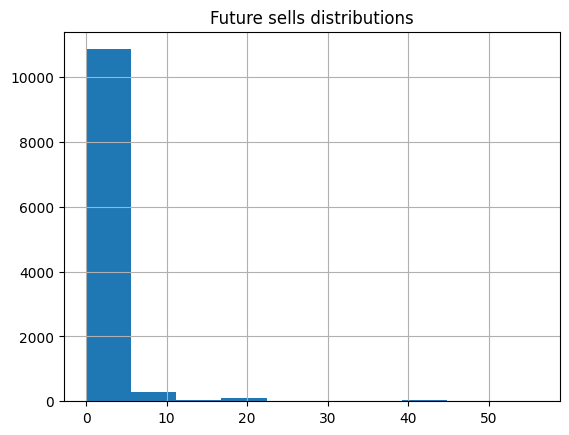

In [97]:
df_future.sales_quantity.hist()
plt.title("Future sells distributions")
plt.show()

# 5 GridSearch for CatBoost:

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [32]:
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1]
}

In [33]:
cb_model = CatBoostRegressor(
    loss_function='MAE',
    random_seed=42,
    verbose=0 ,
    iterations=500
)

fit_params = {
    'cat_features': cat_features,
    'early_stopping_rounds': 50,
    'eval_set': (X_val, y_val)
}

cv = TimeSeriesSplit(n_splits=3)

grid = GridSearchCV(
    cb_model,
    param_grid,
    cv=cv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2,
)

grid.fit(X_train, y_train, **fit_params)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ........................depth=4, learning_rate=0.05; total time= 1.7min
[CV] END .........................depth=4, learning_rate=0.1; total time= 1.8min
[CV] END ........................depth=4, learning_rate=0.05; total time= 2.6min
[CV] END ........................depth=4, learning_rate=0.01; total time= 2.9min
[CV] END .........................depth=4, learning_rate=0.1; total time= 3.2min
[CV] END .........................depth=4, learning_rate=0.1; total time= 1.6min
[CV] END ........................depth=4, learning_rate=0.05; total time= 4.9min
[CV] END ........................depth=6, learning_rate=0.01; total time= 3.2min
[CV] END ........................depth=4, learning_rate=0.01; total time= 5.2min
[CV] END .........................depth=6, learning_rate=0.1; total time= 1.3min
[CV] END ........................depth=6, learning_rate=0.05; total time= 4.0min
[CV] END ........................depth=4, learnin

,estimator,<catboost.cor...t 0x126a08830>
,param_grid,"{'depth': [4, 6, ...], 'learning_rate': [0.01, 0.05, ...]}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False


In [34]:
print("Best params:", grid.best_params_)
print("Best score (MAE):", -grid.best_score_)

Best params: {'depth': 8, 'learning_rate': 0.05}
Best score (MAE): 0.40843623809361373


In [37]:
best_model = grid.best_estimator_

In [70]:
# Validation MAE
y_pred_val = best_model.predict(X_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
print(f"Validation MAE: {mae_val:.3f}")

Validation MAE: 0.487


In [98]:
# Reread future (need index order)
df_future = load_and_prepare_data("../data/raw/df_future.csv", reset_index=False)

# Prediction
y_pred_test_cv = best_model.predict(X_test.loc[df_future.index]) # Same indexes order as in test file
y_pred_test_int_cv = np.round(y_pred_test_cv).clip(min=0).astype(int)
y_pred_test_int_cv

array([0, 1, 0, ..., 0, 1, 0], shape=(11368,))

In [99]:
# Save prediction
df_future = load_and_prepare_data("../data/raw/df_future.csv", reset_index=False)
df_future["sales_quantity"] = y_pred_test_int_cv

# Rewrite result csv
df_future = df_future.sort_index()
df_future.to_csv("../results/df_future.csv")

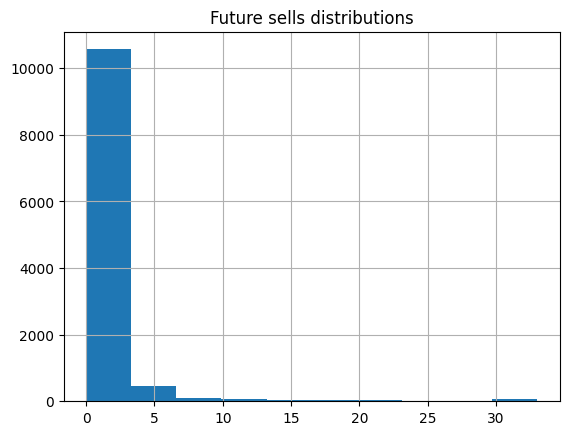

In [100]:
df_future.sales_quantity.hist()
plt.title("Future sells distributions")
plt.show()